# Location selection for restaurants in Mumbai
By Chirag Shetty


<img src="https://www.indexiafinance.com/wp-content/uploads/2017/06/mumbai-sea-link.jpg">

Mumbai is the most populated city in the world and fifth most densely populated city. Its is the financial capital of India and its no surprise that Mumbai is also the restaurant capital of India. The business has flourished with the local food and cuisine as well as multinational franchises. With such over-crowdedness comes cut throat competition. One of the main aspects of starting or expanding a restaurant business is choosing its location. Location of a restaurant decides the amount of traffic in a restaurant which makes it necessary to optimize.

## Lets start by importing necessary libraries

In [2]:
import numpy as np
import googlemaps
import prettyprint as pprint
import time
import pandas as pd
from pandas.io.html import read_html
import geocoder
from geopy.geocoders import Nominatim
import time
import geopy
import folium
import requests 
import json
import sklearn
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from pandas.io.json import json_normalize
from geopy.exc import GeocoderTimedOut
import shapely.geometry
import pyproj
import math
from geopy.extra.rate_limiter import RateLimiter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Lets get the list of Boroughs in Mumbai and their respective pincodes

[Source Link](http://pincode.india-server.com/cities/mumbai/)

In [62]:
url = 'http://pincode.india-server.com/cities/mumbai/'
table = pd.read_html(url, attrs={'class':"pincode-tbl"})

mum_df = table[0]['List of all Mumbai post offices with pincode'][['Post office', 'Pincode']]

Setting the dataframe in required formats and cleaning any unwanted and duplicate values.

In [63]:
mum_df.drop_duplicates(subset ="Pincode", keep = 'first', inplace = True)
mum_df.reset_index(drop=True, inplace=True)
mum_df.sort_values(by='Pincode',  inplace=True)
mum_df.reset_index(drop=True, inplace=True)
mum_df.drop(index=71, inplace=True)
mum_df.reset_index(drop=True, inplace=True)
mum_df.rename(columns={'Post office':'Borough'}, inplace=True)

In [65]:
mum_df.head()

,Borough,Pincode
0,Bazargate,400001
1,Kalbadevi,400002
2,B.P.Lane,400003
3,Ambewadi,400004
4,Asvini,400005


## Lets create a function to find Latitude and longitude for a given pincode using geocoder

In [78]:
from geopy.exc import GeocoderTimedOut

def do_geocode(address, attempt=1, max_attempts=200):
    try:
        geolocator = Nominatim(user_agent="my-geocoder", timeout=10)
        location = geolocator.geocode('{}, Mumbai, Maharashtra'.format(address))
        return location.latitude, location.longitude 
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return do_geocode(address, attempt=attempt+1)
        raise

In [79]:
Latitude = []
Longitude = []

for i in mum_df['Pincode']:
    t = do_geocode(i)
    Latitude.append(t[0])
    Longitude.append(t[1])

Adding the latitudes and longitudes to the main dataframe.

In [81]:
mum_df['Latitude'] = pd.DataFrame(Latitude)
mum_df['Longitude'] = pd.DataFrame(Longitude)
#mum_df.drop(columns='Unnamed: 0', inplace=True, axis=1)

In [82]:
mum_df

,Borough,Pincode,Latitude,Longitude
0,Bazargate,400001,18.938771,72.835335
1,Kalbadevi,400002,18.949439,72.826324
2,B.P.Lane,400003,18.951606,72.834797
3,Ambewadi,400004,18.954329,72.821730
4,Asvini,400005,18.916863,72.824315
5,Malabar Hill,400006,18.944790,72.793776
6,Bharat Nagar,400007,18.965888,72.814797
7,Falkland Road,400008,18.963839,72.831471
8,Chinchbunder,400009,18.959645,72.838526
9,Dockyard Road,400010,19.053122,73.099739


In [83]:
mum_df.to_csv('Mumbai_c.csv')

In [84]:
mum_df = pd.read_csv('Mumbai_c.csv')

## Lets visualize the locations on a map of Mumbai using the folium package

In [85]:
mum_lat = 19.07283 
mum_lng = 72.88261

map_mum = folium.Map(location=[mum_lat, mum_lng], zoom_start=11)

for lat, lng, borough in zip(mum_df['Latitude'], mum_df['Longitude'], mum_df['Borough']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3196cc',
        fill_opacity=0.7,
        parse_html=False,).add_to(map_mum)
    
map_mum

## Setting up Client id and Secret for the foursquare API. 
(Hidden for security reasons)

In [159]:
client_id = '***********************************************' 
client_secret = '**********************************************' 
VERSION = '20180724'
LIMIT = 1000
radius = 7500

## Creating a function to get nearby venues for a given latitude and longitude.

The function will scan a circular area of radius 7.5km around a given latitude and longitude and will output a maximum of 1000 venues per given location. I believe 1000 venues per location could be overkill and is more than enough to study patterns among them.

In [87]:
import time
def getNearbyVenues(names, latitudes, longitudes, radius=7500, verbose=False):
    

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        if verbose:
            print(name)
            

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']
        

        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [88]:
mum_venues = getNearbyVenues(names=mum_df['Borough'],
                                   latitudes=mum_df['Latitude'],
                                   longitudes=mum_df['Longitude']
                                  )
mum_venues.head()

Bazargate
Kalbadevi
B.P.Lane
Ambewadi
Asvini
Malabar Hill
Bharat Nagar
Falkland Road
Chinchbunder
Dockyard Road
Agripada
BEST STaff Quarters
Delisle Road
Dadar Colony
Sewri
Kapad Bazar
Dharavi Road
Worli Naka
Matunga
Central Building
Nariman Point
Chunabhatti
Nehru Nagar
New Prabhadevi Road
Cumballa Hill
V J B Udyan
Bhawani Shankar Rd
A I Staff Colony
Century Mill
Kidwai Nagar
High Court Building
Cotton Exchange
Haji Ali
Rajbhavan
Antop Hill
Bhandup East
D.M. Colony
Juhu
Bandra West
Audit Bhavan
Danda
Andheri
Santacruz Central
Santacruz(East)
IRLA
Hanuman Road
Andheri Railway Station
J.B. Nagar
Jogeshwari East
Madh
Goregaon East
Liberty Garden
Aareymilk Colony
Borivali East
Charkop
Dahisar RS
Andheri East
Kurla North
Chembur
Sakinaka
Chembur Extension
Best Staff Colony
Powai Iit
Rajawadi
Bhandup Ind. Estate
Psm Colony
Mulund Dd Road
Mhada Colony
Bhandup Complex
Kannamwar Nagar
Barve Nagar
Ghatkopar West
NITIE
Govandi
Chembur Rs
Borivali
Borivali West
Chakala Midc
Anushakti Nagar
Ins Ha

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bazargate,18.938771,72.835335,Food for Thought,18.932031,72.831667,Café
1,Bazargate,18.938771,72.835335,Wankhede Stadium,18.938792,72.825944,Cricket Ground
2,Bazargate,18.938771,72.835335,Royal China,18.938715,72.832933,Chinese Restaurant
3,Bazargate,18.938771,72.835335,Starbucks,18.932190,72.833959,Coffee Shop
4,Bazargate,18.938771,72.835335,Britannia & Co.,18.934683,72.840183,Parsi Restaurant


In [89]:
mum_venues.to_csv('Mumbai_venues.csv')

In [90]:
mum_venues = pd.read_csv('Mumbai_venues.csv')

## Exploring the collected data

In [91]:
mum_venues.drop('Unnamed: 0', axis=1).head(11)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bazargate,18.938771,72.835335,Food for Thought,18.932031,72.831667,Café
1,Bazargate,18.938771,72.835335,Wankhede Stadium,18.938792,72.825944,Cricket Ground
2,Bazargate,18.938771,72.835335,Royal China,18.938715,72.832933,Chinese Restaurant
3,Bazargate,18.938771,72.835335,Starbucks,18.932190,72.833959,Coffee Shop
4,Bazargate,18.938771,72.835335,Britannia & Co.,18.934683,72.840183,Parsi Restaurant
5,Bazargate,18.938771,72.835335,Marine Drive,18.941221,72.823261,Scenic Lookout
6,Bazargate,18.938771,72.835335,Trishna,18.928619,72.832356,Seafood Restaurant
7,Bazargate,18.938771,72.835335,Natural's Ice Cream Parlour,18.934892,72.824222,Ice Cream Shop
8,Bazargate,18.938771,72.835335,Jehangir Art Gallery,18.927606,72.831464,Art Gallery
9,Bazargate,18.938771,72.835335,Taj Mahal Palace & Tower,18.922306,72.833578,Hotel


In [92]:
mum_venues['Venue Category'].unique()

array(['Café', 'Cricket Ground', 'Chinese Restaurant', 'Coffee Shop',
       'Parsi Restaurant', 'Scenic Lookout', 'Seafood Restaurant',
       'Ice Cream Shop', 'Art Gallery', 'Hotel', 'Beach',
       'Indian Restaurant', 'Bakery', 'Boutique', 'Diner', 'Dessert Shop',
       'Italian Restaurant', 'Gym / Fitness Center', 'Gift Shop',
       'Performing Arts Venue', 'Nightclub', 'Pub', 'History Museum',
       'Theater', 'Lounge', 'Pizza Place', 'Fast Food Restaurant', 'Bar',
       'Asian Restaurant', 'New American Restaurant',
       'Japanese Restaurant', 'Cocktail Bar', 'Cheese Shop',
       'Thai Restaurant', 'Market', 'Mediterranean Restaurant',
       'Restaurant', 'Flea Market', 'Middle Eastern Restaurant', 'Spa',
       'Juice Bar', 'Music Venue', 'Brewery', 'Golf Course', 'Steakhouse',
       'Park', 'Club House', 'Donut Shop', 'Sandwich Place',
       'Deli / Bodega', 'Stadium', "Men's Store", 'Bengali Restaurant',
       'Shopping Mall', 'Comedy Club', 'Cosmetics Shop',
    

## Converting the Venue categories into Dummy Categorical Variables.
We will use the **pd.get_dummies** for the One hot encoding. We will exclude venues that are not restaurants or related to food.

In [93]:
mum1onehot = pd.get_dummies(mum_venues['Venue Category'], prefix="", prefix_sep="")

mum1onehot['Neighborhood'] = mum_venues['Neighborhood'] 

In [96]:
fixed_columns = ['Neighborhood'] + mum1onehot.columns.drop('Neighborhood').to_list()
mum1onehot = mum1onehot[fixed_columns]

mum_onehot = mum1onehot[['Neighborhood','Indian Restaurant','Chinese Restaurant', 'Bar', 
       'Parsi Restaurant', 'Coffee Shop', 'Café', 'Bakery',
       'Seafood Restaurant', 
       'Ice Cream Shop', 
       'Fast Food Restaurant', 'Dessert Shop', 
       'Asian Restaurant', 'Breakfast Spot',
       'Hotel',  'Pizza Place',
       'Italian Restaurant', 'Japanese Restaurant', 
       'Lounge', 'Pub',
       'Middle Eastern Restaurant', 'Gastropub', 'Diner', 'Brewery',
       'New American Restaurant',
       'Cocktail Bar', 'Donut Shop', 'Restaurant',
       'Mediterranean Restaurant','Falafel Restaurant',
       'BBQ Joint', 'Juice Bar', 'Food',
       'Food Truck', 'Steakhouse',
       'Mexican Restaurant', 'Snack Place',
       'Vegetarian / Vegan Restaurant', 'Irani Cafe', 'Plaza',
       'American Restaurant',  'Sandwich Place', 'Thai Restaurant',
       'French Restaurant', 'Deli / Bodega', 
       'Bengali Restaurant',
       'Cupcake Shop',
       'South Indian Restaurant', 
       'Burger Joint', 'Maharashtrian Restaurant', 'Hotel Bar',
       'Punjabi Restaurant',
       'Modern European Restaurant', 'Goan Restaurant', 
       'Dim Sum Restaurant',  'Mughlai Restaurant',
       'North Indian Restaurant', 'Tea Room', 'Fried Chicken Joint', 
       'Spanish Restaurant', 'Australian Restaurant', 'Hookah Bar',
       'Salad Place',
       'Sushi Restaurant',
       'Bagel Shop', 'Comfort Food Restaurant', 
       'Beer Garden','Bed & Breakfast', 
       'Burrito Place',
       'Afghan Restaurant', 'Dhaba','Burrito Place']]

In [97]:
mum_onehot.head()

,Neighborhood,Indian Restaurant,Chinese Restaurant,Bar,Parsi Restaurant,Coffee Shop,Café,Bakery,Seafood Restaurant,Ice Cream Shop,Fast Food Restaurant,Dessert Shop,Asian Restaurant,Breakfast Spot,Hotel,Pizza Place,Italian Restaurant,Japanese Restaurant,Lounge,Pub,Middle Eastern Restaurant,Gastropub,Diner,Brewery,New American Restaurant,Cocktail Bar,Donut Shop,Restaurant,Mediterranean Restaurant,Falafel Restaurant,BBQ Joint,Juice Bar,Food,Food Truck,Steakhouse,Mexican Restaurant,Snack Place,Vegetarian / Vegan Restaurant,Irani Cafe,Plaza,American Restaurant,Sandwich Place,Thai Restaurant,French Restaurant,Deli / Bodega,Bengali Restaurant,Cupcake Shop,South Indian Restaurant,Burger Joint,Maharashtrian Restaurant,Hotel Bar,Punjabi Restaurant,Modern European Restaurant,Goan Restaurant,Dim Sum Restaurant,Mughlai Restaurant,North Indian Restaurant,Tea Room,Fried Chicken Joint,Spanish Restaurant,Australian Restaurant,Hookah Bar,Salad Place,Sushi Restaurant,Bagel Shop,Comfort Food Restaurant,Beer Garden,Bed & Breakfast,Burrito Place,Afghan Restaurant,Dhaba,Burrito Place
0,Bazargate,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bazargate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bazargate,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bazargate,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bazargate,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Grouping the dataframe by neighborhoods and looking at the number different of restaurants in each Neighborhood

In [99]:
mum_grouped = mum_onehot.groupby('Neighborhood').sum().reset_index()
mum_grouped.head()

,Neighborhood,Indian Restaurant,Chinese Restaurant,Bar,Parsi Restaurant,Coffee Shop,Café,Bakery,Seafood Restaurant,Ice Cream Shop,Fast Food Restaurant,Dessert Shop,Asian Restaurant,Breakfast Spot,Hotel,Pizza Place,Italian Restaurant,Japanese Restaurant,Lounge,Pub,Middle Eastern Restaurant,Gastropub,Diner,Brewery,New American Restaurant,Cocktail Bar,Donut Shop,Restaurant,Mediterranean Restaurant,Falafel Restaurant,BBQ Joint,Juice Bar,Food,Food Truck,Steakhouse,Mexican Restaurant,Snack Place,Vegetarian / Vegan Restaurant,Irani Cafe,Plaza,American Restaurant,Sandwich Place,Thai Restaurant,French Restaurant,Deli / Bodega,Bengali Restaurant,Cupcake Shop,South Indian Restaurant,Burger Joint,Maharashtrian Restaurant,Hotel Bar,Punjabi Restaurant,Modern European Restaurant,Goan Restaurant,Dim Sum Restaurant,Mughlai Restaurant,North Indian Restaurant,Tea Room,Fried Chicken Joint,Spanish Restaurant,Australian Restaurant,Hookah Bar,Salad Place,Sushi Restaurant,Bagel Shop,Comfort Food Restaurant,Beer Garden,Bed & Breakfast,Burrito Place,Afghan Restaurant,Dhaba,Burrito Place
0,A I Staff Colony,11,2,5,0,5,6,3,4,4,0,2,0,2,6,2,1,0,2,2,0,0,1,3,0,1,3,2,1,1,0,1,0,2,0,0,2,1,0,1,2,2,0,0,0,1,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,Aareymilk Colony,12,1,2,0,6,4,3,1,3,2,3,1,0,2,1,5,0,2,3,0,1,0,1,0,0,4,2,0,0,0,0,0,0,0,0,3,0,0,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,Agripada,12,2,4,0,2,4,4,4,3,1,4,1,0,4,1,1,0,3,2,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,1,5,0,2,1,0,0,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Airport,9,1,3,0,5,5,6,4,3,1,5,1,0,6,2,2,0,3,2,0,0,1,1,0,0,1,3,1,0,0,2,0,1,0,0,0,0,0,1,1,0,0,1,2,0,2,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,Ambewadi,7,2,2,1,2,3,1,2,3,3,5,1,0,6,3,1,2,2,2,1,0,2,0,1,1,1,2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preparing a graph for 10 most popular types of restaurant in Mumbai

In [102]:
graphs = mum_grouped.set_index('Neighborhood')
graphs_sum = graphs[['Indian Restaurant','Café','Dessert Shop','Coffee Shop','Ice Cream Shop','Bar','Bakery','Fast Food Restaurant','Chinese Restaurant','Pizza Place', ]].sum(axis=0) / 2954 * 100
y = list((graphs_sum.values)*100)

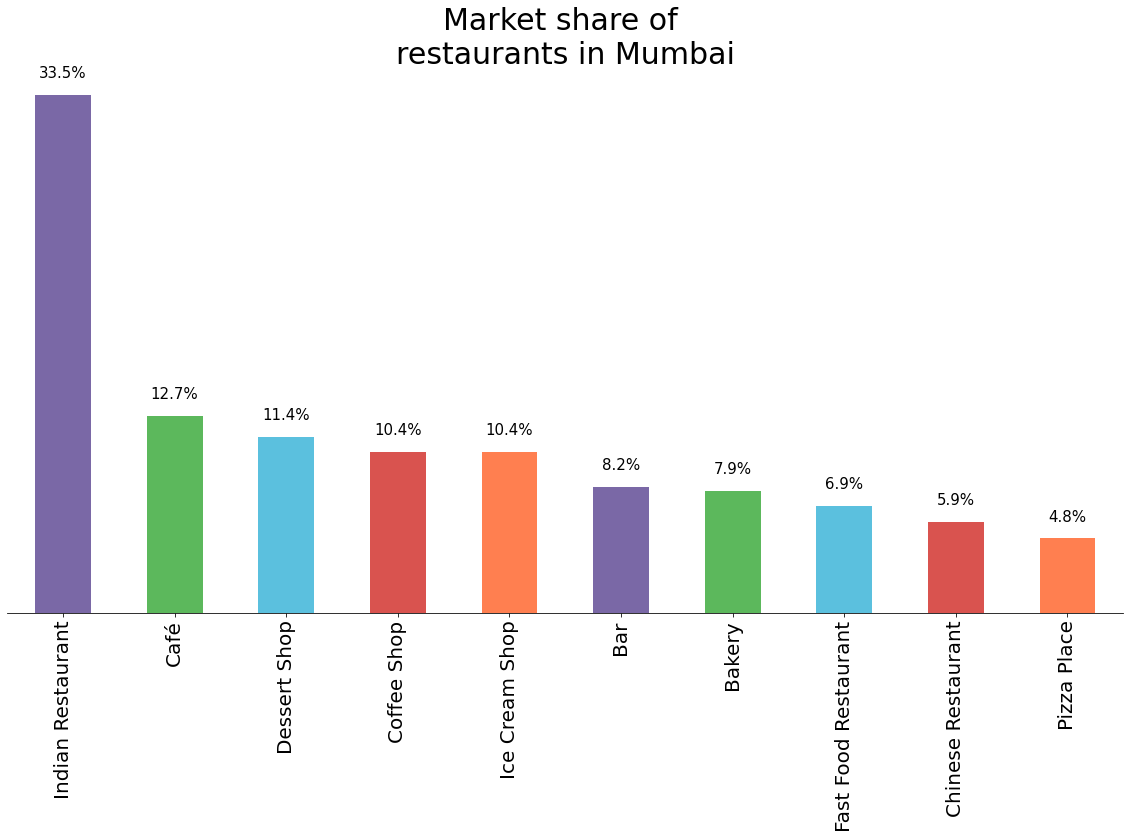

In [103]:
plt.figure(figsize=(20,10))
ax = graphs_sum.plot(kind='bar', x=graphs_sum.index.to_list(),y = y, 
                color=['#7a68a6','#5cb85c','#5bc0de','#d9534f','coral', ],  fontsize=20)
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(),decimals=1)) + '%', 
                (p.get_x()+p.get_width()/2., p.get_height()+0.5), 
                ha='center', 
                #va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 15, 
               )

plt.xticks(rotation=90)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Market share of \nrestaurants in Mumbai',fontsize=30)
plt.savefig('Mumbai.png')

Indian restaurants are the most popular in Mumbai, with about 33% of market share. People in India are very culturally rooted and prefer having food with family in familiar setting which is the reason for the popularity of Indian restaurants. But the younger generation have more inclination towards Cafe's and Coffee places. These places have trendy ambience and the youth like to hangout there after work and college with their friends. The popularity is in an upward trend with Cafe's and Coffee houses, already having a hefty 23% market share. The market may have been saturated with Indian restaurants but there is still room left for Cafe's and Coffee places for expansion.

## Creating a function to output the most common venues in a neighborhood.

In [105]:
num_top_venues = 10

for hood in mum_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mum_grouped[mum_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----A I Staff Colony----
                venue  freq
0   Indian Restaurant  11.0
1               Hotel   6.0
2                Café   6.0
3                 Bar   5.0
4         Coffee Shop   5.0
5  Seafood Restaurant   4.0
6      Ice Cream Shop   4.0
7              Bakery   3.0
8          Donut Shop   3.0
9             Brewery   3.0


----Aareymilk Colony----
                venue  freq
0   Indian Restaurant  12.0
1         Coffee Shop   6.0
2  Italian Restaurant   5.0
3          Donut Shop   4.0
4                Café   4.0
5      Ice Cream Shop   3.0
6                 Pub   3.0
7        Dessert Shop   3.0
8         Snack Place   3.0
9              Bakery   3.0


----Agripada----
                venue  freq
0   Indian Restaurant  12.0
1       Deli / Bodega   5.0
2        Dessert Shop   4.0
3                 Bar   4.0
4                Café   4.0
5              Bakery   4.0
6  Seafood Restaurant   4.0
7               Hotel   4.0
8          Restaurant   3.0
9              Lounge   3.0


---

9          Restaurant   3.0


----Chembur Rs----
                  venue  freq
0     Indian Restaurant  11.0
1                 Hotel   5.0
2          Dessert Shop   5.0
3                  Café   4.0
4        Ice Cream Shop   4.0
5            Restaurant   4.0
6                   Bar   3.0
7  Fast Food Restaurant   3.0
8                Bakery   2.0
9                 Diner   2.0


----Chinchbunder----
                  venue  freq
0     Indian Restaurant   7.0
1                 Hotel   6.0
2          Dessert Shop   4.0
3                  Café   3.0
4        Ice Cream Shop   3.0
5  Fast Food Restaurant   3.0
6           Pizza Place   3.0
7                 Diner   2.0
8                   Pub   2.0
9                Lounge   2.0


----Chunabhatti----
                venue  freq
0   Indian Restaurant  16.0
1               Hotel   5.0
2  Seafood Restaurant   4.0
3        Dessert Shop   4.0
4      Ice Cream Shop   4.0
5          Restaurant   4.0
6                Café   3.0
7              Bakery 

9        Sandwich Place   3.0


----Kannamwar Nagar----
                venue  freq
0   Indian Restaurant  20.0
1               Hotel   7.0
2          Restaurant   6.0
3         Coffee Shop   5.0
4              Lounge   5.0
5  Italian Restaurant   5.0
6        Dessert Shop   4.0
7                Café   3.0
8                 Pub   3.0
9      Ice Cream Shop   3.0


----Kapad Bazar----
                venue  freq
0   Indian Restaurant   8.0
1                Café   5.0
2  Seafood Restaurant   4.0
3              Lounge   4.0
4               Hotel   4.0
5       Deli / Bodega   4.0
6          Restaurant   4.0
7                 Bar   4.0
8              Bakery   3.0
9        Dessert Shop   3.0


----Kidwai Nagar----
                venue  freq
0   Indian Restaurant  12.0
1       Deli / Bodega   5.0
2  Seafood Restaurant   5.0
3                Café   4.0
4              Bakery   4.0
5               Hotel   4.0
6         Coffee Shop   3.0
7        Dessert Shop   3.0
8                 Bar   3.0
9  

In [115]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Preparing the data to apply various Clustering Algorithms

In [108]:
mum_grouped_clustering = mum_grouped.set_index(keys='Neighborhood')

Applying agglomerative/heirarchical clustering.

In [109]:
agglom = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average', affinity='l1')
agglom.fit(mum_grouped_clustering)

AgglomerativeClustering(affinity='l1', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0,
                        linkage='average', memory=None, n_clusters=None)

## Function to plot a dendrogram for Agglomerative Clustering.

In [110]:
def plot_dendrogram(model, **kwargs):
   
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

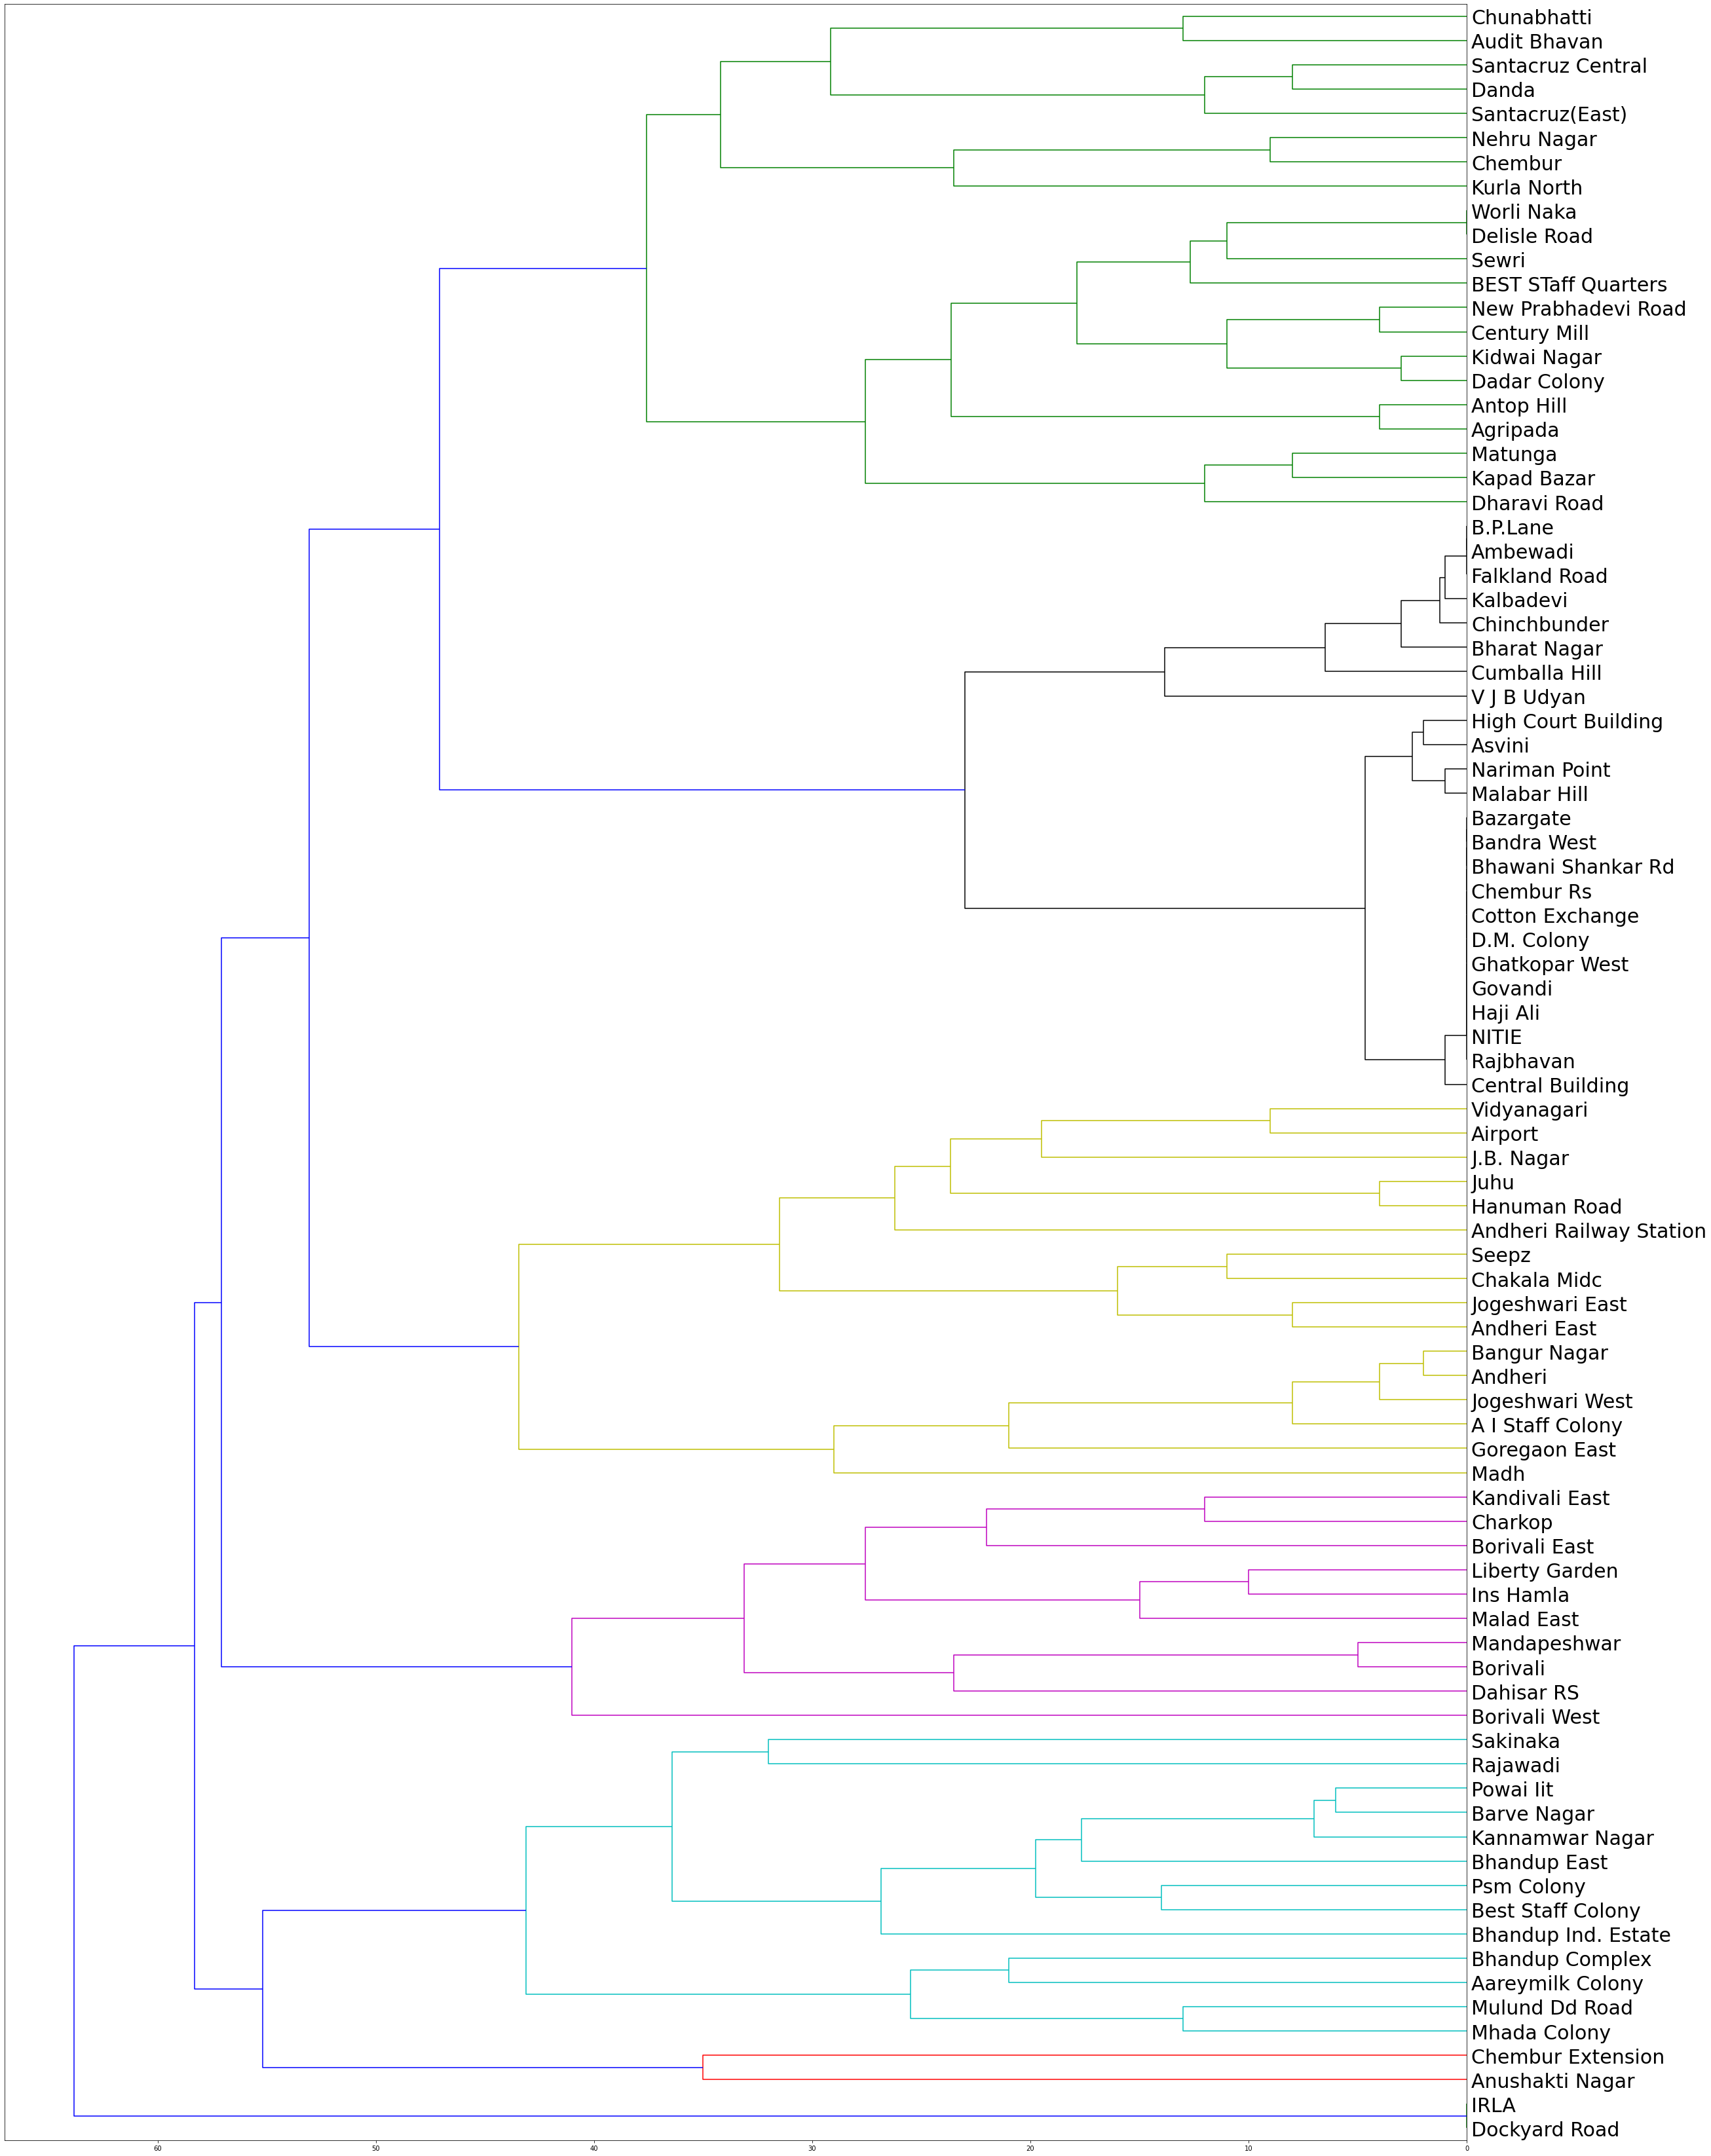

In [111]:
plt.figure(figsize=(40,60))
plot_dendrogram(agglom, truncate_mode='level',p=85, labels=mum_grouped_clustering.index, orientation='left', leaf_font_size=30)
plt.savefig('Dendrogram.png')

Here we see a highly co-related neighborhood with virtually zero distance between them in the distance matrix, the locations being Bazargate, Bandra, Bhawani Shankar Road, Chembur, Cotton Exchange, DM Colony, Ghatkopar, Govandi, Haji Ali, NITIE and Raj Bhavan areas. 

In [120]:
kmeans = KMeans(n_clusters = 7, algorithm='full')
kmeans.fit(mum_grouped_clustering)
labels = kmeans.labels_
labels

array([1, 5, 3, 1, 4, 1, 1, 1, 3, 6, 2, 3, 4, 3, 2, 1, 6, 2, 6, 5, 6, 6,
       4, 2, 0, 0, 0, 2, 3, 1, 0, 3, 6, 2, 4, 3, 2, 4, 2, 3, 0, 3, 3, 3,
       4, 4, 2, 1, 2, 2, 1, 2, 4, 0, 1, 1, 1, 1, 4, 0, 6, 3, 3, 3, 0, 1,
       2, 0, 0, 3, 5, 5, 2, 2, 3, 3, 6, 6, 6, 2, 6, 3, 3, 1, 3, 4, 1, 3])

Lets find the top ten most common venues in each neighborhoods.

In [131]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']


columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_grouped['Neighborhood']

for ind in np.arange(mum_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,A I Staff Colony,Indian Restaurant,Café,Hotel,Bar,Coffee Shop
1,Aareymilk Colony,Indian Restaurant,Coffee Shop,Italian Restaurant,Donut Shop,Café
2,Agripada,Indian Restaurant,Deli / Bodega,Bar,Café,Bakery
3,Airport,Indian Restaurant,Hotel,Bakery,Coffee Shop,Café
4,Ambewadi,Indian Restaurant,Hotel,Dessert Shop,Café,Pizza Place


In [132]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)

In [133]:
mum_merged = mum_df

mum_merged = mum_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Borough')

mum_merged.dropna(inplace=True, subset=['Borough','Pincode','Latitude','Longitude','Cluster Labels','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue'])

Lets visualize the clusters of Neighborhoods given by Kmeans Algorithm

In [149]:
map_clusters = folium.Map(location=[mum_lat, mum_lng], zoom_start=10)
kclusters = len(set(labels))

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster, common in zip(mum_merged['Latitude'], mum_merged['Longitude'], mum_merged['Borough'], mum_merged['Cluster Labels'], mum_merged['2nd Most Common Venue']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) +'\n' 'Most common venue is ' + str(common), parse_html=True)
    folium.Circle([lat, lon], radius=1000, color='#00000000', fill=True, fill_color=rainbow[int(cluster)-1], fill_opacity=0.25).add_to(map_clusters)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='darkslateblue',
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Even though we didn't train the model on any location based data we shouldn't be surprised that closer neighborhoods are more similar to each other, this indicates a good model.

Lets have a look at the cluster that interests us the most.

In [128]:
mum_merged.loc[mum_merged['Cluster Labels'] == 2, mum_merged.columns[[1] + list(range(5, mum_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bazargate,2,Indian Restaurant,Hotel,Dessert Shop,Café,Restaurant
4,Asvini,2,Indian Restaurant,Dessert Shop,Café,Hotel,Ice Cream Shop
5,Malabar Hill,2,Indian Restaurant,Ice Cream Shop,Dessert Shop,Café,Hotel
19,Central Building,2,Indian Restaurant,Hotel,Dessert Shop,Café,Ice Cream Shop
20,Nariman Point,2,Indian Restaurant,Dessert Shop,Café,Hotel,Ice Cream Shop
26,Bhawani Shankar Rd,2,Indian Restaurant,Hotel,Dessert Shop,Café,Restaurant
30,High Court Building,2,Indian Restaurant,Hotel,Dessert Shop,Café,Ice Cream Shop
31,Cotton Exchange,2,Indian Restaurant,Hotel,Dessert Shop,Café,Restaurant
32,Haji Ali,2,Indian Restaurant,Hotel,Dessert Shop,Café,Restaurant
33,Rajbhavan,2,Indian Restaurant,Hotel,Dessert Shop,Café,Restaurant


This group of neighborhoods have a lot in common as both Agglomerative and Kmeans clustering clustered them into the same group. Once we start out at any one of these locations it would be easier to expand in other locations. Here we also see that Indian restaurants are popular other than that Dessert shops are quite popular too. I would like to add that most dessert shops in India tend to be Sweet shops and confectionaries, they are not a restaurant per se but are quite popular. I would like to focus on the Coffe shops and Cafe's here. The area is not saturated with it but we see they are quite popular too. I would also like to focus on the Bandra region of the cluster. Bandra is located at the heart of the city with lot of foot traffic around it. The Bandra Kurla Complex in Bandra is considered the financial hub of the city. I have attached a news article to solidify my reasons for choosing Bandra as our location of Interest.

<img src="https://static.toiimg.com/photo/imgsize-382443,msid-66531419/66531419.jpg">


[News Article on Bandra Kurla Complex](https://timesofindia.indiatimes.com/city/mumbai/bkc-wasteland-to-landmark-of-mumbai/articleshow/66531407.cms)

## So now we have chosen Bandra as our Borough and Cafe/Coffee House as our restaurant type.

**Lets have a look at the market share of various types of Restaurants in Bandra**

In [137]:
bandra_g = graphs.loc['Bandra West'][:31]
y = bandra_g.sort_values(ascending=False,).head(10)
y_g = []
for i in y:
    y_g.append(i/73 * 100)
    
x_g = y.index.to_list()
pdf = pd.DataFrame()
pdf['X'] = x_g
pdf['Y'] = y_g

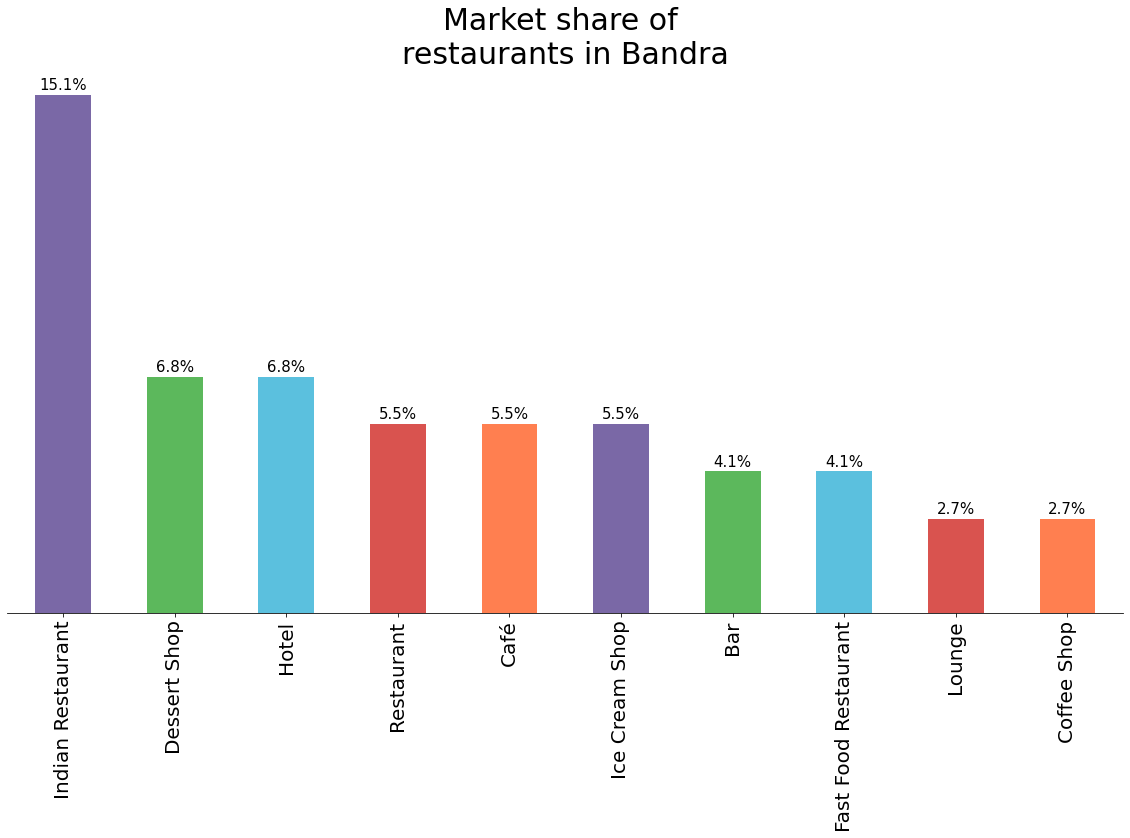

In [138]:
ax1 = pdf.plot(kind='bar', x='X',y = 'Y', 
                color=['#7a68a6','#5cb85c','#5bc0de','#d9534f','coral', ],  fontsize=20, figsize=(20,10), legend=None)
for p in ax1.patches:
    ax1.annotate(str(np.round(p.get_height(),decimals=1)) + '%', 
                (p.get_x()+p.get_width()/2., p.get_height()+0.15), 
                ha='center', 
                va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize = 15, 
               )

plt.xticks(rotation=90)
plt.xlabel('')
ax1.get_yaxis().set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_title('Market share of \nrestaurants in Bandra',fontsize=30)
plt.savefig('Bandra.png')

We can see that Cafe's and Coffee shops are quite common but not as common as they are in the rest of Mumbai, this gives us ample opportunity for expansion and also doesn't risk us oversaturating the market. 

Now lets shift our focus to Bandra Kurla Complex and obtain its Latitude and Longitude Values.

In [139]:
address = 'Bandra Kurla Complex'
bandra = do_geocode(address)
print('Coordinate of {}: {}'.format(address, bandra))

Coordinate of Bandra Kurla Complex: (19.067115, 72.8657245)


## Lets create a function to convert latitude and longitude into X-Y coordinates and vice-versa

In [151]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Checking Coordinate Transformation')

print('Bandra longitude={}, latitude={}'.format(bandra[1], bandra[0]))
x, y = lonlat_to_xy(bandra[1], bandra[0])
print('Bandra location in X-Y coordinates X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Bandra longitude={}, latitude={}'.format(lo, la))

Checking Coordinate Transformation
Bandra longitude=72.8657245, latitude=19.067115
Bandra location in X-Y coordinates X=7518459.29588162, Y=3670620.0392347835
Bandra longitude=72.86572450000003, latitude=19.067114999996914


## Lets create a grid of equally spaced points around Bandra Kurla Complex (BKC) while also calculating the distance of those grid points from BKC

In [152]:
bandra_x, bandra_y = lonlat_to_xy(bandra[1], bandra[0])

k = math.sqrt(3) / 2 
x_min = bandra_x - 6000
x_step = 600
y_min = bandra_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_bkc = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_bkc = calc_xy_distance(bandra_x, bandra_y, x, y)
        if (distance_from_bkc <= 5001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_bkc.append(distance_from_bkc)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'Location centres created.')

254 Location centres created.


## Lets visualize the grid

In [77]:
map_bandra = folium.Map(location=bandra, zoom_start=13)
folium.Marker(bandra, popup='Bandra').add_to(map_bandra)


for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=3, color='blue', fill=False).add_to(map_bandra)
    folium.Circle([lat, lon], radius=190, color='#00000000',fill_color='blue', fill=True, fill_opacity=0.1).add_to(map_bandra)

map_bandra

Reverse geocoding the grid points to obtain their addresses.

In [26]:
locator = Nominatim(user_agent='myGeocoder', timeout=10)

In [27]:
df = pd.DataFrame()

In [28]:
df['Latitude'] = latitudes
df['Longitude'] = longitudes

In [29]:
address = []
for i ,j in zip(df['Latitude'], df['Longitude']):
    coordinates = [i,j]
    location = locator.reverse(coordinates)
    address.append(location.raw)

add = []
for i in range(len(address)):
    add.append(address[i]['display_name'])

In [154]:
df['Address'] = add
df['Distance from BKC'] = distances_from_bkc
df['X'] = xs
df['Y'] = ys

columns = ['Address', 'Distance from BKC', 'Latitude', 'Longitude', 'X', 'Y']
df = df[columns]

In [155]:
df.head()

,Address,Distance from BKC,Latitude,Longitude,X,Y
0,"Mahim Sion Link Road, Central Govt Staff Colon...",4828.043082,19.047763,72.847333,7.517259e+06,3.665944e+06
1,"Dharavi, Mahim Sion Link Road, Dharavi, Zone 2...",4714.870094,19.046257,72.850352,7.517859e+06,3.665944e+06
2,"Dharavi, Zone 2, Mumbai, Mumbai City, Maharash...",4676.537180,19.044751,72.853370,7.518459e+06,3.665944e+06
3,"Kamaraj Building, 90 Feet Road, Dharavi, Zone ...",4714.870094,19.043244,72.856387,7.519059e+06,3.665944e+06
4,"Mahatma Gandhi Road, Dharavi, Zone 2, Mumbai, ...",4828.043082,19.041738,72.859405,7.519659e+06,3.665944e+06


In [118]:
import pickle
df.to_pickle('./locations.pkl')   

## Initializing the foursqaure API to get nearby venues for the given grid points.
(Hidden for security reasons)

In [156]:
client_id = '***********************************************' 
client_secret = '**********************************************' 
version = '20180604'
limit = 1000
radius = 50000

In [157]:
food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues '4bf58dd8d48988d16e941735'

cafe_restaurant_categories = ['4bf58dd8d48988d1e0931735','4bf58dd8d48988d16d941735', '4bf58dd8d48988d128941735','52e81612bcbc57f1066b79f1']

def is_restaurant(categories, specific_filter=None):
    restaurant_words = ['cafe', 'cofee shop', 'cafeteria', 'restaurant', 'hotel', 'diner','bistro','fine dining']
    restaurant = False
    specific = False
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in restaurant_words:
            if r in category_name:
                restaurant = True
        if 'Mayoniese' in category_name:
            restaurant = False
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
            restaurant = True
    return restaurant, specific

def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', India', '')
    address = address.replace(', Maharashtra', '')
    return address

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues

In [158]:
import pickle

def get_restaurants(lats, lons):
    restaurants = {}
    cafe_restaurants = {}
    location_restaurants = []

    
    for lat, lon in zip(lats, lons):
       
        venues = get_venues_near_location(lat, lon, food_category, client_id, client_secret, radius=350, limit=100)
        area_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_res, is_cafe = is_restaurant(venue_categories, specific_filter=cafe_restaurant_categories)
            if is_res:
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_cafe, x, y)
                if venue_distance<=300:
                    area_restaurants.append(restaurant)
                restaurants[venue_id] = restaurant
                if is_cafe:
                    cafe_restaurants[venue_id] = restaurant
        location_restaurants.append(area_restaurants)
        print('|', end='')
    print(' Done.')
    return restaurants, cafe_restaurants, location_restaurants


restaurants = {}
cafe_restaurants = {}
location_restaurants = []
loaded = False
try:
    with open('restaurants_350.pkl', 'rb') as f:
        restaurants = pickle.load(f)
    with open('cafe_restaurants_350.pkl', 'rb') as f:
        cafe_restaurants = pickle.load(f)
    with open('location_restaurants_350.pkl', 'rb') as f:
        location_restaurants = pickle.load(f)
    print('Data already loaded.')
    loaded = True
except:
    pass


if not loaded:
    restaurants, cafe_restaurants, location_restaurants = get_restaurants(latitudes, longitudes)
    
    # Let's persists this in local file system
    with open('restaurants_350.pkl', 'wb') as f:
        pickle.dump(restaurants, f)
    with open('cafe_restaurants_350.pkl', 'wb') as f:
        pickle.dump(cafe_restaurants, f)
    with open('location_restaurants_350.pkl', 'wb') as f:
        pickle.dump(location_restaurants, f)
        

Data already loaded.


## Lets take a look at the loaded data.

In [160]:
print('Total number of restaurants:', len(restaurants))
print('Total number of Cafe:', len(cafe_restaurants))
print('Percentage of Cafe restaurants: {:.2f}%'.format(len(cafe_restaurants) / len(restaurants) * 100))
print('Average number of restaurants in neighborhood:', np.array([len(r) for r in location_restaurants]).mean())


Total number of restaurants: 288
Total number of Cafe: 43
Percentage of Cafe restaurants: 14.93%
Average number of restaurants in neighborhood: 1.8818897637795275


In [161]:
print('Restaurants around location')
print('***************************')
for i in range(0, 254):
    rs = location_restaurants[i][:8]
    names = ', '.join([r[1] for r in rs])
    print('Restaurants around location {}: {}'.format(i+1, names))

Restaurants around location
***************************
Restaurants around location 1: 
Restaurants around location 2: Sizzle N Grill, The Tasting Room
Restaurants around location 3: The Tasting Room
Restaurants around location 4: 
Restaurants around location 5: Guru Kripa, Seven Sevens
Restaurants around location 6: Hind bar & restaurant, Yaadgaar, Bombay Blue, Riyaz Restaurant
Restaurants around location 7: Ching Ki Shack
Restaurants around location 8: Ching Ki Shack
Restaurants around location 9: Sweta Palace, Sizzle N Grill
Restaurants around location 10: Mukta's, Jhakas Family Restaurant, Sizzle N Grill, The Tasting Room
Restaurants around location 11: Shubham veg restaurant
Restaurants around location 12: 
Restaurants around location 13: Guru Kripa, Peninsula, Cafe Vrindavan, Modern Lunch Home, Central Peninsula, Sion, cafe istaa, Hanuman Veg Restaurant, Amrut veg restaurant
Restaurants around location 14: Peninsula Next, Peninsula, Central Peninsula, Sion, Hanuman Veg Restaurant

## Lets visualize the ratio of Restaurants to Cafe's near Bandra Kurla Complex

Purple - Restaurants  
Orange - Cafe/Coffee House

In [164]:
map_bkc = folium.Map(location=bandra, zoom_start=13)
folium.Marker(bandra, popup='Bandra Kurla Complex').add_to(map_bkc)
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_cafe = res[6]
    color = 'coral' if is_cafe else 'slateblue'
    folium.CircleMarker([lat, lon], radius=7.5, color='white', fill=True, fill_color=color, fill_opacity=1).add_to(map_bkc)   
map_bkc

Lets find the number of restaurants in each gridpoints

In [165]:
location_restaurants_count = [len(res) for res in location_restaurants]

df['Restaurants in area'] = location_restaurants_count

print('Average number of restaurants in every area with radius=300m:', np.array(location_restaurants_count).mean())

df.head(10)

Average number of restaurants in every area with radius=300m: 1.8818897637795275


,Address,Distance from BKC,Latitude,Longitude,X,Y,Restaurants in area
0,"Mahim Sion Link Road, Central Govt Staff Colon...",4828.043082,19.047763,72.847333,7.517259e+06,3.665944e+06,0
1,"Dharavi, Mahim Sion Link Road, Dharavi, Zone 2...",4714.870094,19.046257,72.850352,7.517859e+06,3.665944e+06,2
2,"Dharavi, Zone 2, Mumbai, Mumbai City, Maharash...",4676.537180,19.044751,72.853370,7.518459e+06,3.665944e+06,1
3,"Kamaraj Building, 90 Feet Road, Dharavi, Zone ...",4714.870094,19.043244,72.856387,7.519059e+06,3.665944e+06,0
4,"Mahatma Gandhi Road, Dharavi, Zone 2, Mumbai, ...",4828.043082,19.041738,72.859405,7.519659e+06,3.665944e+06,2
5,"Quresh Nagar Hutment Colony, Bandra West, Zone...",4956.813493,19.054016,72.841159,7.515759e+06,3.666463e+06,4
6,"Sion Bandra Link Road, Gandhi Nagar, H/E Ward,...",4657.252409,19.052509,72.844178,7.516359e+06,3.666463e+06,1
7,"Sion Bandra Link Road, Kala Nagar, H/E Ward, Z...",4419.275959,19.051002,72.847196,7.516959e+06,3.666463e+06,1
8,"Sion Bandra Link Road, Dharavi, Zone 2, Mumbai...",4253.234064,19.049496,72.850215,7.517559e+06,3.666463e+06,2
9,"Sion Bandra Link Road, Cooperative Housing Soc...",4167.733197,19.047989,72.853233,7.518159e+06,3.666463e+06,4


Lets find the distance from nearest Cafe in each gridpoints

In [166]:
distances_to_cafe = []

for area_x, area_y in zip(xs, ys):
    min_distance = 10000
    for res in cafe_restaurants.values():
        res_x = res[7]
        res_y = res[8]
        d = calc_xy_distance(area_x, area_y, res_x, res_y)
        if d<min_distance:
            min_distance = d
    distances_to_cafe.append(min_distance)

df['Distance to Cafe'] = distances_to_cafe

In [167]:
df.head()

,Address,Distance from BKC,Latitude,Longitude,X,Y,Restaurants in area,Distance to Cafe
0,"Mahim Sion Link Road, Central Govt Staff Colon...",4828.043082,19.047763,72.847333,7.517259e+06,3.665944e+06,0,1370.153093
1,"Dharavi, Mahim Sion Link Road, Dharavi, Zone 2...",4714.870094,19.046257,72.850352,7.517859e+06,3.665944e+06,2,1504.217666
2,"Dharavi, Zone 2, Mumbai, Mumbai City, Maharash...",4676.537180,19.044751,72.853370,7.518459e+06,3.665944e+06,1,1226.457727
3,"Kamaraj Building, 90 Feet Road, Dharavi, Zone ...",4714.870094,19.043244,72.856387,7.519059e+06,3.665944e+06,0,1043.107953
4,"Mahatma Gandhi Road, Dharavi, Zone 2, Mumbai, ...",4828.043082,19.041738,72.859405,7.519659e+06,3.665944e+06,2,552.324877


In [168]:
print('Average distance to closest Cafe from each area:', df['Distance to Cafe'].mean())

Average distance to closest Cafe from each area: 933.8631241906407


On an average people walk 1km to get to a Cafe. This means there is room for improvement here.

In [169]:
restaurant_latlons = [[res[2], res[3]] for res in restaurants.values()]

cafe_latlons = [[res[2], res[3]] for res in cafe_restaurants.values()]

## Lets use a heatmap to visualize the density of restaurants near gridpoints

In [171]:
from folium import plugins
from folium.plugins import HeatMap

map_bkc = folium.Map(location=bandra, zoom_start=14)
HeatMap(restaurant_latlons).add_to(map_bkc)
folium.Marker(bandra).add_to(map_bkc)
folium.Circle(bandra, radius=1000, fill=False, color='slateblue').add_to(map_bkc)
folium.Circle(bandra, radius=2000, fill=False, color='slateblue').add_to(map_bkc)
folium.Circle(bandra, radius=3000, fill=False, color='slateblue').add_to(map_bkc)
map_bkc

Looks like BKC is densely populated with restaurants but lets visulaize the density of Cafes near BKC.

In [172]:
map_bkc = folium.Map(location=bandra, zoom_start=14)

HeatMap(cafe_latlons).add_to(map_bkc)
folium.Marker(bandra).add_to(map_bkc)
folium.Circle(bandra, radius=1000, fill=False, color='slateblue').add_to(map_bkc)
folium.Circle(bandra, radius=2000, fill=False, color='slateblue').add_to(map_bkc)
folium.Circle(bandra, radius=3000, fill=False, color='slateblue').add_to(map_bkc)

map_bkc

Wow! looks like Cafe's are a rare breed here, especially to the region just north of BKC. The region near Mumbai University could be of great value as the target demographic requirement is met in this region.

We have further narrowed our search to a region just north of Bandra Kurla Complex, highlighted in the next cell

In [173]:
roi_x_min = bandra_x - 3000
roi_y_max = bandra_y + 3500
roi_width = 5000
roi_height = 5000
roi_center_x = roi_x_min + 2500
roi_center_y = roi_y_max - 2500
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_bkc = folium.Map(location=roi_center, zoom_start=15)
HeatMap(restaurant_latlons).add_to(map_bkc)
folium.Marker(bandra).add_to(map_bkc)
folium.Circle(roi_center, radius=1000, color='slateblue', fill=True, fill_opacity=0.25).add_to(map_bkc)

map_bkc

## Lets have a look at our competiton here.

In [175]:
roi_x_min = bandra_x - 3000
roi_y_max = bandra_y + 3500
roi_width = 5000
roi_height = 5000
roi_center_x = roi_x_min + 2500
roi_center_y = roi_y_max - 2500
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_bkc = folium.Map(location=roi_center, zoom_start=15)
HeatMap(cafe_latlons).add_to(map_bkc)
folium.Marker(bandra).add_to(map_bkc)
folium.Circle(roi_center, radius=1000, color='slateblue', fill=True, fill_opacity=0.25).add_to(map_bkc)

map_bkc

Wow! looks like we dont have to worry about much competition here.

## Lets repeat the earlier process of making gridpoints to study the place better

In [176]:
k = math.sqrt(3) / 2 
x_step = 200
y_step = 200 * k 
roi_y_min = roi_center_y - 2500

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(51/k)):
    y = roi_y_min + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x = roi_x_min + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 2501):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'Locations created.')

565 Locations created.


Lets create a function to count the number of restaurants nearby and distance to nearest restaurants.

In [181]:
def count_restaurants_nearby(x, y, restaurants, radius=250):    
    count = 0
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_restaurant(x, y, restaurants):
    d_min = 100000
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min

roi_restaurant_counts = []
roi_cafe_distances = []


for x, y in zip(roi_xs, roi_ys):
    count = count_restaurants_nearby(x, y, restaurants, radius=250)
    roi_restaurant_counts.append(count)
    distance = find_nearest_restaurant(x, y, cafe_restaurants)
    roi_cafe_distances.append(distance)
print('Done.')


Done.


## Creating a new Dataframe 

In [182]:
df_roi_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Restaurants nearby':roi_restaurant_counts,
                                 'Distance to Cafe':roi_cafe_distances})

df_roi_locations.head(10)

,Latitude,Longitude,X,Y,Restaurants nearby,Distance to Cafe
0,19.061324,72.858994,7.517909e+06,3.669120e+06,1,431.330522
1,19.064289,72.855176,7.517059e+06,3.669293e+06,0,768.290035
2,19.063786,72.856182,7.517259e+06,3.669293e+06,0,790.070732
3,19.063284,72.857188,7.517459e+06,3.669293e+06,1,603.257036
4,19.062781,72.858194,7.517659e+06,3.669293e+06,2,428.516443
5,19.062278,72.859200,7.517859e+06,3.669293e+06,1,288.675651
6,19.061776,72.860206,7.518059e+06,3.669293e+06,1,251.079512
7,19.061273,72.861212,7.518259e+06,3.669293e+06,0,350.354408
8,19.060771,72.862218,7.518459e+06,3.669293e+06,5,512.304110
9,19.060268,72.863223,7.518659e+06,3.669293e+06,5,694.379429


## Making a Dataframe that contains all the potential candidates for location

In [183]:
good_res_count = np.array((df_roi_locations['Restaurants nearby']<=2))
print('Locations with no more than two restaurants nearby:', good_res_count.sum())

good_cafe_distance = np.array(df_roi_locations['Distance to Cafe']>=400)
print('Locations with no Cafes within 400m:', good_cafe_distance.sum())

good_locations = np.logical_and(good_res_count, good_cafe_distance)
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_roi_locations[good_locations]

Locations with no more than two restaurants nearby: 510
Locations with no Cafes within 400m: 487
Locations with both conditions met: 457


Visualizing the Dataframe using gridpoints

In [184]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

map_berlin = folium.Map(location=roi_center, zoom_start=15)

HeatMap(restaurant_latlons).add_to(map_berlin)
folium.Circle(roi_center, radius=1500, color='white', fill=True, fill_opacity=0.1).add_to(map_berlin)
folium.Marker(bandra).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.1).add_to(map_berlin) 

map_berlin

Visualizing the Dataframe using gridpoints and heatmap

In [185]:
map_bkc = folium.Map(location=roi_center, zoom_start=15)

HeatMap(good_locations, radius=25).add_to(map_bkc)
folium.Marker(bandra).add_to(map_bkc)

for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_bkc)

map_bkc

## Lets apply Kmeans clustering to obtain the clusters of good locations and their centres.
Visualizing the clusters using folium

In [186]:
from sklearn.cluster import KMeans

number_of_clusters = 7

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

map_bkc = folium.Map(location=roi_center, zoom_start=15)

HeatMap(restaurant_latlons).add_to(map_bkc)
folium.Circle(roi_center, radius=1750, color='white', fill=True, fill_opacity=0.4).add_to(map_bkc)
folium.Marker(bandra).add_to(map_bkc)
for lon, lat in cluster_centers:
    folium.CircleMarker([lat, lon], radius=4, color='red', fill=True).add_to(map_bkc)
    folium.Circle([lat, lon], radius=400, color='red', fill=True, fill_opacity=0.25).add_to(map_bkc)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_bkc)

map_bkc

## Doing a reverse Geocode to get the addresses of the cluster centres for setting up a Cafe

In [187]:
candidate_area_addresses = []
print('*******************************************************************************************')
print('Addresses of centers of areas recommended for Closer Look ')
print('*******************************************************************************************\n')
for lon, lat in cluster_centers:
    coordinates = [lat, lon]
    location = locator.reverse(coordinates)
    addr=location.raw['display_name'].replace(', Mumbai Suburban, Maharashtra,', '')
    candidate_area_addresses.append(location.raw)    
    x, y = lonlat_to_xy(lon, lat)
    d = calc_xy_distance(x, y, bandra_x, bandra_y)
    print('{}{} \n {:.1f}km from Bandra Kurla Complex'.format(addr, ' '*(50-len(addr)), d/1000))
    print('\n')
    print('--------------------------------------------------------------------------------------------\n')

*******************************************************************************************
Addresses of centers of areas recommended for Closer Look 
*******************************************************************************************

Mumbai University, Sant Dnyaneshwar Marg, RPF Colony, H/E Ward, Zone 3, Mumbai 40051, India 
 1.6km from Bandra Kurla Complex


--------------------------------------------------------------------------------------------

Kolivery Village, H/E Ward, Zone 3, Mumbai 400098, India 
 2.7km from Bandra Kurla Complex


--------------------------------------------------------------------------------------------

H/E Ward, Zone 3, Mumbai 400 051, India            
 0.9km from Bandra Kurla Complex


--------------------------------------------------------------------------------------------

Kolivery Village, H/E Ward, Zone 3, Mumbai 400098, India 
 3.0km from Bandra Kurla Complex


-------------------------------------------------------------------------

# We have suggested a total of 7 locations near Bandra Kurla Complex which can be given a further look and analysis to open a Cafe or Coffee House.